In [1]:
# NBVAL_SKIP
from jax import config
#config.update("jax_enable_x64", True)
config.update('jax_num_cpu_devices', 2)

In [2]:
#NBVAL_SKIP
import os

# Tell XLA to fake 2 host CPU devices
#os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=3'

# Only make GPU 0 and GPU 1 visible to JAX:
#os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5'

#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]   = "false"

import jax

# Now JAX will list two CpuDevice entries
print(jax.devices())
# → [CpuDevice(id=0), CpuDevice(id=1)]

[CpuDevice(id=0), CpuDevice(id=1)]


In [3]:
# NBVAL_SKIP
#import os
#  os.environ['SPS_HOME'] = '/mnt/storage/annalena_data/sps_fsps'
#os.environ['SPS_HOME'] = '/home/annalena/sps_fsps'
os.environ['SPS_HOME'] = '/Users/annalena/Documents/GitHub/fsps'
#os.environ['SPS_HOME'] = '/export/home/aschaibl/fsps'
#os.environ['SPS_HOME'] = '/home/annalena_data/sps_fsps'

# RUBIX pipeline

RUBIX is designed as a linear pipeline, where the individual functions are called and constructed as a pipeline. This allows as to execude the whole data transformation from a cosmological hydrodynamical simulation of a galaxy to an IFU cube in two lines of code. This notebook shows, how to execute the pipeline. To see, how the pipeline is execuded in small individual steps per individual function, we refer to the notebook `rubix_pipeline_stepwise.ipynb`.

## How to use the Pipeline
1) Define a `config`
2) Setup the `pipeline yaml`
3) Run the RUBIX pipeline
4) Do science with the mock-data

## Step 1: Config

The `config` contains all the information needed to run the pipeline. Those are run specfic configurations. Currently we just support Illustris as simulation, but extensions to other simulations (e.g. NIHAO) are planned.

For the `config` you can choose the following options:
- `pipeline`: you specify the name of the pipeline that is stored in the yaml file in rubix/config/pipeline_config.yml
- `logger`: RUBIX has implemented a logger to report the user, what is happening during the pipeline execution and give warnings
- `data - args - particle_type`: load only stars particle ("particle_type": ["stars"]) or only gas particle ("particle_type": ["gas"]) or both ("particle_type": ["stars","gas"])
- `data - args - simulation`: choose the Illustris simulation (e.g. "simulation": "TNG50-1")
- `data - args - snapshot`: which time step of the simulation (99 for present day)
- `data - args - save_data_path`: set the path to save the downloaded Illustris data
- `data - load_galaxy_args - id`: define, which Illustris galaxy is downloaded
- `data - load_galaxy_args - reuse`: if True, if in th esave_data_path directory a file for this galaxy id already exists, the downloading is skipped and the preexisting file is used
- `data - subset`: only a defined number of stars/gas particles is used and stored for the pipeline. This may be helpful for quick testing
- `simulation - name`: currently only IllustrisTNG is supported
- `simulation - args - path`: where the data is stored and how the file will be named
- `output_path`: where the hdf5 file is stored, which is then the input to the RUBIX pipeline
- `telescope - name`: define the telescope instrument that is observing the simulation. Some telescopes are predefined, e.g. MUSE. If your instrument does not exist predefined, you can easily define your instrument in rubix/telescope/telescopes.yaml
- `telescope - psf`: define the point spread function that is applied to the mock data
- `telescope - lsf`: define the line spread function that is applied to the mock data
- `telescope - noise`: define the noise that is applied to the mock data
- `cosmology`: specify the cosmology you want to use, standard for RUBIX is "PLANCK15"
- `galaxy - dist_z`: specify at which redshift the mock-galaxy is observed
- `galaxy - rotation`: specify the orientation of the galaxy. You can set the types edge-on or face-on or specify the angles alpha, beta and gamma as rotations around x-, y- and z-axis
- `ssp - template`: specify the simple stellar population lookup template to get the stellar spectrum for each stars particle. In RUBIX frequently "BruzualCharlot2003" is used.

In [4]:
# NBVAL_SKIP
import matplotlib.pyplot as plt
from rubix.core.pipeline import RubixPipeline 
import os

config_TNG = {
    "pipeline":{"name": "calc_ifu_dusty_memory"},
    
    "logger": {
        "log_level": "DEBUG",
        "log_file_path": None,
        "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    },
    "data": {
        "name": "IllustrisAPI",
        "args": {
            "api_key": os.environ.get("ILLUSTRIS_API_KEY"),
            "particle_type": ["stars", "gas"],
            "simulation": "TNG50-1",
            "snapshot": 99,
            "save_data_path": "data",
        },
        
        "load_galaxy_args": {
        "id": 14,
        "reuse": True,
        },
        
        "subset": {
            "use_subset": True,
            "subset_size": 100000,
        },
    },
    "simulation": {
        "name": "IllustrisTNG",
        "args": {
            "path": "data/galaxy-id-12.hdf5",
        },
    
    },
    "output_path": "output",

    "telescope":
        {"name": "MUSE",
         "psf": {"name": "gaussian", "size": 5, "sigma": 0.6},
         "lsf": {"sigma": 0.5},
         "noise": {"signal_to_noise": 100,"noise_distribution": "normal"},},
    "cosmology":
        {"name": "PLANCK15"},
        
    "galaxy":
        {"dist_z": 0.1,
         "rotation": {"type": "edge-on"},
        },
        
    "ssp": {
        "template": {
            "name": "FSPS", #"Mastar_CB19_SLOG_1_5"
        },
        "dust": {
                "extinction_model": "Cardelli89",
                "dust_to_gas_ratio": 0.01,
                "dust_to_metals_ratio": 0.4,
                "dust_grain_density": 3.5,
                "Rv": 3.1,
            },
    },        
}

2025-06-28 13:02:49,750 - rubix - INFO - 
   ___  __  _____  _____  __
  / _ \/ / / / _ )/  _/ |/_/
 / , _/ /_/ / _  |/ /_>  <
/_/|_|\____/____/___/_/|_|


2025-06-28 13:02:49,750 - rubix - INFO - Rubix version: 0.0.post427+g131f0ec.d20250602
2025-06-28 13:02:49,750 - rubix - INFO - JAX version: 0.5.0
2025-06-28 13:02:49,750 - rubix - INFO - Running on [CpuDevice(id=0), CpuDevice(id=1)] devices


## Step 3: Run the pipeline

After defining the `config` and the `pipeline_config` you can simply run the whole pipeline by these two lines of code.

In [5]:
#NBVAL_SKIP
pipe = RubixPipeline(config_TNG)

/Users/annalena/Documents/GitHub/rubix/rubix/telescope/factory.py:26: UserWarning: No telescope config provided, using default stored in /Users/annalena/Documents/GitHub/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(


In [6]:
#NBVAL_SKIP

inputdata = pipe.prepare_data()
rubixdata = pipe.run_sharded(inputdata)

2025-06-28 13:02:50,062 - rubix - INFO - Getting rubix data...
2025-06-28 13:02:50,063 - rubix - INFO - Loading data from IllustrisAPI
2025-06-28 13:02:50,064 - rubix - INFO - Reusing existing file galaxy-id-14.hdf5. If you want to download the data again, set reuse=False.
2025-06-28 13:02:50,079 - rubix - INFO - Loading data into input handler
2025-06-28 13:02:50,081 - rubix - DEBUG - Loading data from Illustris file..
2025-06-28 13:02:50,081 - rubix - DEBUG - Checking if the fields are present in the file...
2025-06-28 13:02:50,081 - rubix - DEBUG - Keys in the file: <KeysViewHDF5 ['Header', 'PartType4', 'SubhaloData']>
2025-06-28 13:02:50,081 - rubix - DEBUG - Expected fields: ['Header', 'SubhaloData', 'PartType4', 'PartType0']
2025-06-28 13:02:50,081 - rubix - DEBUG - Matching fields: {'PartType4', 'SubhaloData', 'Header'}
2025-06-28 13:02:50,085 - rubix - DEBUG - Found 649384 valid particles out of 649384
2025-06-28 13:02:50,319 - rubix - DEBUG - Converting Stellar Formation Time 

Converted to Rubix format!


2025-06-28 13:02:55,584 - rubix - WARNING - The Subset value is set in config. Using only subset of size 100000 for stars
2025-06-28 13:02:55,586 - rubix - INFO - Data loaded with 100000 star particles and 0 gas particles.
2025-06-28 13:02:55,587 - rubix - INFO - Setting up the pipeline...
2025-06-28 13:02:55,587 - rubix - DEBUG - Pipeline Configuration: {'Transformers': {'rotate_galaxy': {'name': 'rotate_galaxy', 'depends_on': None, 'args': [], 'kwargs': {}}, 'filter_particles': {'name': 'filter_particles', 'depends_on': 'rotate_galaxy', 'args': [], 'kwargs': {}}, 'spaxel_assignment': {'name': 'spaxel_assignment', 'depends_on': 'filter_particles', 'args': [], 'kwargs': {}}, 'calculate_dusty_datacube_particlewise': {'name': 'calculate_dusty_datacube_particlewise', 'depends_on': 'spaxel_assignment', 'args': [], 'kwargs': {}}, 'convolve_psf': {'name': 'convolve_psf', 'depends_on': 'calculate_dusty_datacube_particlewise', 'args': [], 'kwargs': {}}, 'convolve_lsf': {'name': 'convolve_lsf',

AttributeError: 'StarsData' object has no attribute 'masses'

In [ ]:
config_TNG_dustfree = {
    "pipeline":{"name": "calc_ifu_memory"},
    
    "logger": {
        "log_level": "DEBUG",
        "log_file_path": None,
        "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    },
    "data": {
        "name": "IllustrisAPI",
        "args": {
            "api_key": os.environ.get("ILLUSTRIS_API_KEY"),
            "particle_type": ["stars", "gas"],
            "simulation": "TNG50-1",
            "snapshot": 99,
            "save_data_path": "data",
        },
        
        "load_galaxy_args": {
        "id": 11,
        "reuse": True,
        },
        
        "subset": {
            "use_subset": True,
            "subset_size": 100000,
        },
    },
    "simulation": {
        "name": "IllustrisTNG",
        "args": {
            "path": "data/galaxy-id-12.hdf5",
        },
    
    },
    "output_path": "output",

    "telescope":
        {"name": "MUSE",
         "psf": {"name": "gaussian", "size": 5, "sigma": 0.6},
         "lsf": {"sigma": 0.5},
         "noise": {"signal_to_noise": 100,"noise_distribution": "normal"},},
    "cosmology":
        {"name": "PLANCK15"},
        
    "galaxy":
        {"dist_z": 0.1,
         "rotation": {"type": "edge-on"},
        },
        
    "ssp": {
        "template": {
            "name": "FSPS", #"Mastar_CB19_SLOG_1_5"
        },
        "dust": {
                "extinction_model": "Cardelli89",
                "dust_to_gas_ratio": 0.01,
                "dust_to_metals_ratio": 0.4,
                "dust_grain_density": 3.5,
                "Rv": 3.1,
            },
    },        
}

In [ ]:
#NBVAL_SKIP
pipe = RubixPipeline(config_TNG_dustfree)

/Users/annalena/Documents/GitHub/rubix/rubix/telescope/factory.py:26: UserWarning: No telescope config provided, using default stored in /Users/annalena/Documents/GitHub/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(


In [ ]:
#NBVAL_SKIP

inputdata_dustfree = pipe.prepare_data()
rubixdata_dustfree = pipe.run_sharded(inputdata_dustfree)

2025-06-28 12:20:12,234 - rubix - INFO - Getting rubix data...
2025-06-28 12:20:12,235 - rubix - INFO - Rubix galaxy file already exists, skipping conversion
2025-06-28 12:20:12,256 - rubix - INFO - Centering stars particles
2025-06-28 12:20:12,490 - rubix - WARNING - The Subset value is set in config. Using only subset of size 50000 for stars
2025-06-28 12:20:12,494 - rubix - INFO - Centering gas particles
2025-06-28 12:20:12,514 - rubix - WARNING - The Subset value is set in config. Using only subset of size 50000 for gas
2025-06-28 12:20:12,516 - rubix - INFO - Data loaded with 50000 star particles and 50000 gas particles.
2025-06-28 12:20:12,516 - rubix - INFO - Setting up the pipeline...
2025-06-28 12:20:12,516 - rubix - DEBUG - Pipeline Configuration: {'Transformers': {'rotate_galaxy': {'name': 'rotate_galaxy', 'depends_on': None, 'args': [], 'kwargs': {}}, 'filter_particles': {'name': 'filter_particles', 'depends_on': 'rotate_galaxy', 'args': [], 'kwargs': {}}, 'spaxel_assignmen

In [ ]:
#print(rubixdata)

## Step 4: Mock-data

Now we have our final datacube and can use the mock-data to do science. Here we have a quick look in the optical wavelengthrange of the mock-datacube and show the spectra of a central spaxel and a spatial image.

In [ ]:
#NBVAL_SKIP
import jax.numpy as jnp

wave = pipe.telescope.wave_seq
# get the indices of the visible wavelengths of 4000-8000 Angstroms
visible_indices = jnp.where((wave >= 4000) & (wave <= 8000))


This is how you can access the spectrum of an individual spaxel, the wavelength can be accessed via `pipe.wave_seq`

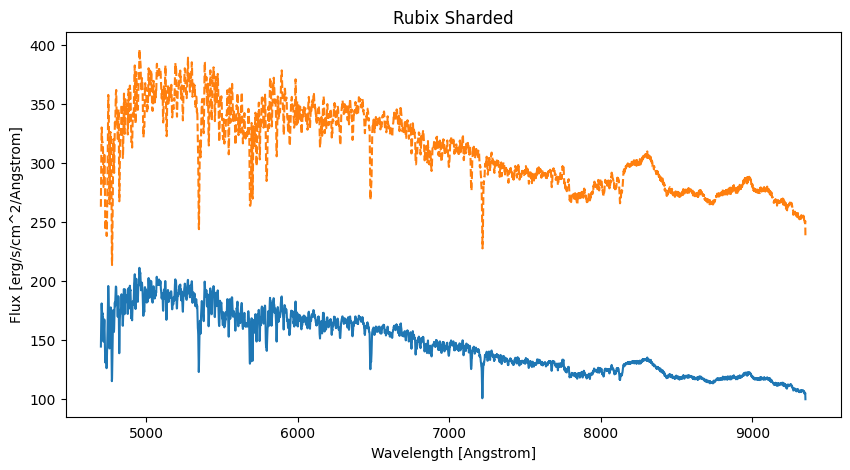

In [ ]:
#NBVAL_SKIP
wave = pipe.telescope.wave_seq

#spectra = rubixdata#.stars.datacube # Spectra of all stars
spectra_sharded = rubixdata # Spectra of all stars
spectra_sharded_dustfree = rubixdata_dustfree # Spectra of all stars
#print(spectra.shape)

plt.figure(figsize=(10, 5))
#plt.subplot(1, 2, 1)
#plt.title("Rubix")
#plt.xlabel("Wavelength [Angstrom]")
#plt.ylabel("Flux [erg/s/cm^2/Angstrom]")
#plt.plot(wave, spectra[12,12,:])
#plt.plot(wave, spectra[8,12,:])

#plt.subplot(1, 2, 2)
plt.title("Rubix Sharded")
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Flux [erg/s/cm^2/Angstrom]")
#plt.plot(wave, spectra_sharded[21,15,:])
#plt.plot(wave, spectra_sharded[15,21,:])
plt.plot(wave, spectra_sharded[13,4,:])
#plt.plot(wave, spectra_sharded[4,13,:])
#plt.plot(wave, spectra_sharded_dustfree[21,15,:], linestyle='--')
#plt.plot(wave, spectra_sharded_dustfree[15,21,:], linestyle='--')
plt.plot(wave, spectra_sharded_dustfree[13,4,:], linestyle='--')
#plt.plot(wave, spectra_sharded_dustfree[4,13,:], linestyle='--')

plt.show()

Plot a spacial image of the data cube

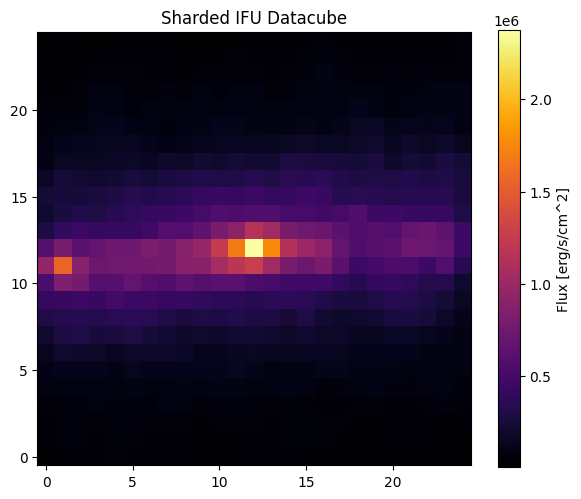

In [ ]:
#NBVAL_SKIP
import numpy as np
# get the spectra of the visible wavelengths from the ifu cube
#visible_spectra = rubixdata.stars.datacube[ :, :, visible_indices[0]]
#visible_spectra = rubixdata[ :, :, visible_indices[0]]
sharded_visible_spectra = rubixdata[ :, :, visible_indices[0]]
#visible_spectra.shape

#image = jnp.sum(visible_spectra, axis=2)
sharded_image = jnp.sum(sharded_visible_spectra, axis=2)
img32 = np.array(sharded_image, dtype=np.float32)

# Plot side by side
plt.figure(figsize=(6, 5))

# Original IFU datacube image
#im0 = axes[0].imshow(image, origin="lower", cmap="inferno")
#axes[0].set_title("Original IFU Datacube")
#fig.colorbar(im0, ax=axes[0])

# Sharded IFU datacube image
plt.imshow(img32, origin="lower", cmap="inferno")#, vmin=0, vmax=1e5)
plt.title("Sharded IFU Datacube")
#plt.colorbar(label="Flux [erg/s/cm^2]")

plt.tight_layout()
plt.show()

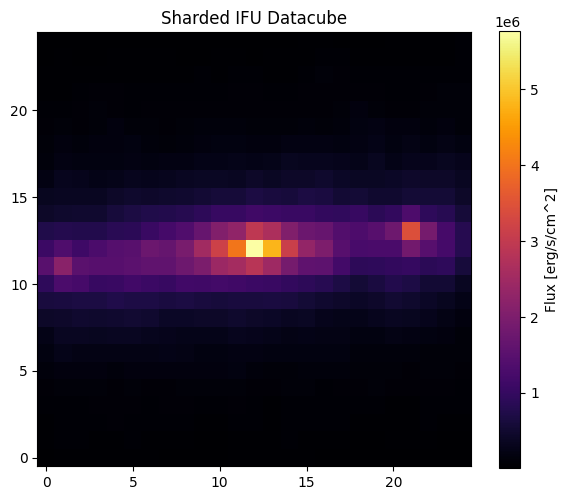

In [ ]:
#NBVAL_SKIP
import numpy as np
# get the spectra of the visible wavelengths from the ifu cube
#visible_spectra = rubixdata.stars.datacube[ :, :, visible_indices[0]]
#visible_spectra = rubixdata[ :, :, visible_indices[0]]
sharded_visible_spectra = rubixdata_dustfree[ :, :, visible_indices[0]]
#visible_spectra.shape

#image = jnp.sum(visible_spectra, axis=2)
sharded_image = jnp.sum(sharded_visible_spectra, axis=2)
img32 = np.array(sharded_image, dtype=np.float32)

# Plot side by side
plt.figure(figsize=(6, 5))

# Original IFU datacube image
#im0 = axes[0].imshow(image, origin="lower", cmap="inferno")
#axes[0].set_title("Original IFU Datacube")
#fig.colorbar(im0, ax=axes[0])

# Sharded IFU datacube image
plt.imshow(img32, origin="lower", cmap="inferno")#, vmin=0, vmax=1e5)
plt.title("Sharded IFU Datacube")
#plt.colorbar(label="Flux [erg/s/cm^2]")

plt.tight_layout()
plt.show()

## DONE!

Congratulations, you have sucessfully run the RUBIX pipeline to create your own mock-observed IFU datacube! Now enjoy playing around with the RUBIX pipeline and enjoy doing amazing science with RUBIX :)